In [9]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import yfinance as yf


yff = yf.download("AAPL", start="2019-12-19", end="2019-12-19")
print(yff.head())




C:\Users\apurv\AppData\Local\Temp\ipykernel_31856\2323955529.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  yff = yf.download("AAPL", start="2019-12-19", end="2019-12-19")
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2019-12-19 -> 2019-12-19)')


Empty DataFrame
Columns: [(Adj Close, AAPL), (Close, AAPL), (High, AAPL), (Low, AAPL), (Open, AAPL), (Volume, AAPL)]
Index: []
Empty DataFrame
Columns: [(Adj Close, AAPL), (Close, AAPL), (High, AAPL), (Low, AAPL), (Open, AAPL), (Volume, AAPL)]
Index: []


In [2]:
import os
import time
import pandas as pd
import yfinance as yf

#tried example usage for the yfinance dataset

ticker = "AAPL"
start_date = "2019-12-01"
end_date = "2019-12-31"
data = yf.download(ticker, start=start_date, end=end_date, group_by='ticker')
if not data.empty:
    print(data.head())
    # Save to CSV
    output_dir = "../data/Stock-Market-Data/yf"
    os.makedirs(output_dir, exist_ok=True)
    data.to_csv(os.path.join(output_dir, f"{ticker}.csv"))

C:\Users\apurv\AppData\Local\Temp\ipykernel_44840\4075712434.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date, group_by='ticker')
[*********************100%***********************]  1 of 1 completed

Ticker           AAPL                                            
Price            Open       High        Low      Close     Volume
Date                                                             
2019-12-02  64.486742  64.723198  63.565060  63.736366   94487200
2019-12-03  62.324875  62.619237  61.837494  62.599937  114430400
2019-12-04  62.990805  63.531269  62.896703  63.152458   67181600
2019-12-05  63.647072  64.153760  63.391316  64.078957   74424400
2019-12-06  64.537422  65.386723  64.493986  65.316750  106075600


In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler

def flatten_columns(df):
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = ['_'.join(map(str, col)).strip() for col in df.columns.values]
    return df

# Preprocess yfinance data for LSTM
def preprocess_data(data, sequence_length=60):
    # Flatten columns if MultiIndex
    data = flatten_columns(data)
    
    if 'AAPL_Close' not in data.columns:
        raise KeyError("'AAPL_Close' column is missing. Available columns: " + ", ".join(map(str, data.columns)))
    
  
    data['return'] = data['AAPL_Close'].pct_change()
    data = data.dropna()  # Drop rows with NaN values

    # Select features and scale them
    features = ['return', 'AAPL_Volume']
    if not all(col in data.columns for col in features):
        raise KeyError("One or more required columns are missing. Available columns: " + ", ".join(map(str, data.columns)))
    
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(data[features])

    X, y = [], []
    for i in range(len(scaled_features) - sequence_length):
        X.append(scaled_features[i:i + sequence_length])
        y.append(scaled_features[i + sequence_length, 0])  
    
    X, y = np.array(X), np.array(y)
    print(f"Created {len(X)} sequences of shape {X.shape}")
    return X, y, scaler

sequence_length = 60
X, y, scaler = preprocess_data(data, sequence_length)

Created 14 sequences of shape (14, 5, 2)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking

# Build the LSTM model with variable sequence length
model = Sequential([
    Masking(mask_value=0.0, input_shape=(None, X_train.shape[2])),  # Mask padded values (if any)
    LSTM(64, return_sequences=False),  # LSTM with variable sequence length
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

c:\Users\apurv\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        17,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,265 (75.25 KB)

 Trainable params: 19,265 (75.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.4507 - mae: 0.5859 - val_loss: 0.7982 - val_mae: 0.6859
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.4507 - mae: 0.5859 - val_loss: 0.7982 - val_mae: 0.6859
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.4342 - mae: 0.5757 - val_loss: 0.7970 - val_mae: 0.6879
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.4342 - mae: 0.5757 - val_loss: 0.7970 - val_mae: 0.6879
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.4272 - mae: 0.5667 - val_loss: 0.7958 - val_mae: 0.6893
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.4272 - mae: 0.5667 - val_loss: 0.7958 - val_mae: 0.6893
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.4228 - mae: 0.5662 - val_loss: 0.7939 - val_mae: 0.6900
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.4228 - mae: 0.5662 - val_loss: 0.7939 - val_mae: 0.6900
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.4291 - mae: 0.5701 - val_

Model saved to ../models/lstm_stock_model.h5


In [9]:
print(data.shape)
print(data.head())

(20, 6)
            AAPL_Open  AAPL_High   AAPL_Low  AAPL_Close  AAPL_Volume    return
Date                                                                          
2019-12-02  64.486742  64.723198  63.565060   63.736366     94487200       NaN
2019-12-03  62.324875  62.619237  61.837494   62.599937    114430400 -0.017830
2019-12-04  62.990805  63.531269  62.896703   63.152458     67181600  0.008826
2019-12-05  63.647072  64.153760  63.391316   64.078957     74424400  0.014671
2019-12-06  64.537422  65.386723  64.493986   65.316750    106075600  0.019317


In [14]:
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Attention
from tensorflow.keras.models import Model


inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))

#lstm layer, has return sequences, returns true for every time step
lstm_out = LSTM(64, return_sequences=True)(inputs)

#attention layer because we need to add attention
attention_out = Attention()([lstm_out, lstm_out])

dropout_out = Dropout(0.2)(attention_out)
dense_out = Dense(32, activation='relu')(dropout_out)
outputs = Dense(1, activation='linear')(dense_out)


model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()


early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Save the model
model.save('../models/lstm_stock_model_with_attention_fixed.h5')
print("Model saved to ../models/lstm_stock_model_with_attention_fixed.h5")

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 5, 2)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 5, 64)     │     17,152 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_2         │ (None, 5, 64)     │          0 │ lstm_3[0][0],     │
│ (Attention)         │                   │            │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 5, 64)     │          0 │ attention_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 5, 32)     │      2,080 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 5, 1)      │         33 │ dense_6[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 19,265 (75.25 KB)

 Trainable params: 19,265 (75.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.4512 - mae: 0.5784 - val_loss: 0.7956 - val_mae: 0.6879
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.4512 - mae: 0.5784 - val_loss: 0.7956 - val_mae: 0.6879
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.4504 - mae: 0.5790 - val_loss: 0.7879 - val_mae: 0.6838
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.4504 - mae: 0.5790 - val_loss: 0.7879 - val_mae: 0.6838
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.4495 - mae: 0.5800 - val_loss: 0.7807 - val_mae: 0.6799
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.4495 - mae: 0.5800 - val_loss: 0.7807 - val_mae: 0.6799
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.4489 - mae: 0.5807 - val_loss: 0.7742 - val_mae: 0.6761
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.4489 - mae: 0.5807 - val_loss: 0.7742 - val_mae: 0.6761
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.4485 - mae: 0.5815 - val_

Model saved to ../models/lstm_stock_model_with_attention_fixed.h5


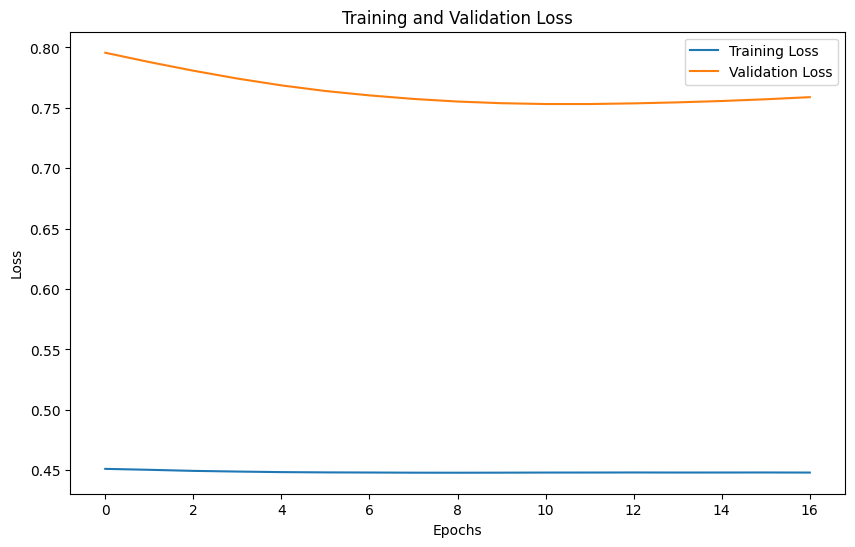

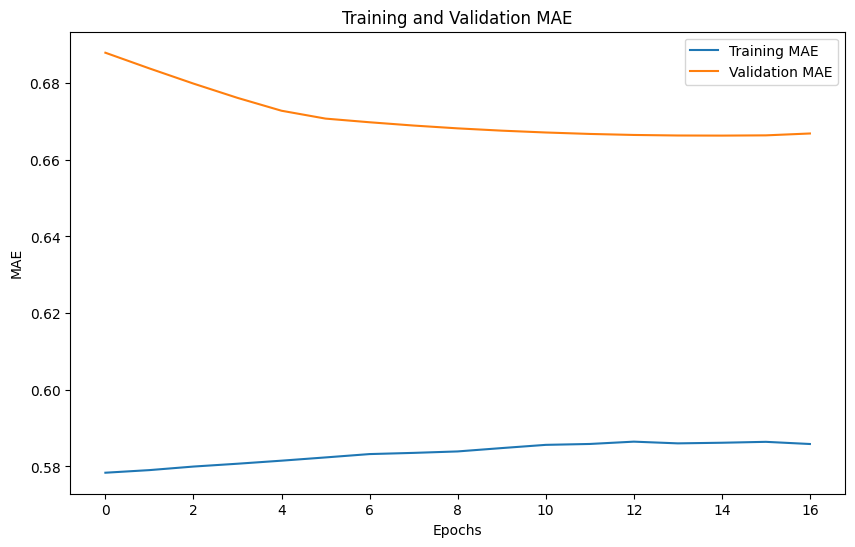

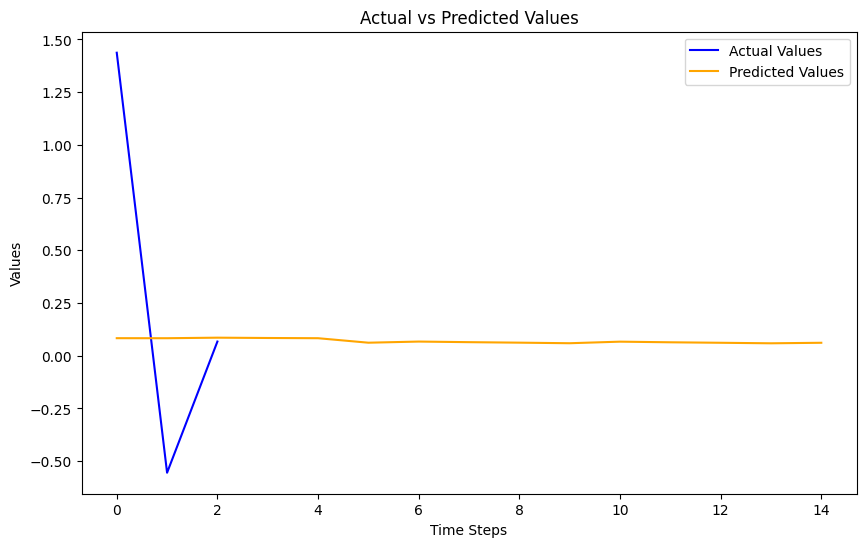

In [16]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.figure(figsize=(10, 6))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

#the y_test has a shape of (3,) which is 1D but the predictions has a 3D array shape of (3, 1, 1)
predictions_flat = predictions.flatten()

# Compare predictions with actual values
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Values', color='blue')
plt.plot(predictions_flat, label='Predicted Values', color='orange')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.legend()
plt.show()